In [62]:
from os import path
import os
from matplotlib.image import imread
from matplotlib import pyplot as plt
import numpy as np
from skimage import io


In [14]:
TRAIN_IMG_FOLDER = "./ORL_dataset_split/train"
TEST_IMG_FOLDER = "./ORL_dataset_split/test"

path.exists(TRAIN_IMG_FOLDER) and path.exists(TEST_IMG_FOLDER)


True

In [78]:
train_set_files = os.listdir(TRAIN_IMG_FOLDER)
test_set_files = os.listdir(TEST_IMG_FOLDER)
#test_set_files, train_set_files

# every image in the folder is having size 70x80

height = 80
width = 70

print(
    f"training: {len(train_set_files)} pics, testing: {len(test_set_files)} pics")


training: 328 pics, testing: 82 pics


In [70]:
training_matrix = np.ndarray(
    shape=(len(train_set_files), height*width), dtype=np.float64)
# training_matrix


In [79]:
img_num = 0
for img_path in train_set_files:
    img_abs_path = "./ORL_dataset_split/train/"+img_path
    # print(img_abs_path)
    img = io.imread(img_abs_path, as_gray=True)
    # plt.imshow(img,cmap="gray") #displays pic

    training_matrix[img_num:] = np.array(img, dtype='float64').flatten()
    img_num += 1

training_matrix.shape


(328, 5600)

In [83]:
mean_face = np.zeros((1, height*width))
for i in training_matrix:
    mean_face = np.add(mean_face, i)

mean_face.shape


(1, 5600)

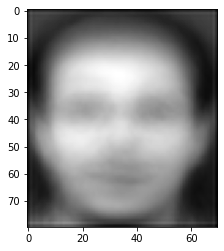

In [84]:
mean_face = np.divide(mean_face, float(len(train_set_files))).flatten()
plt.imshow(mean_face.reshape(height, width), cmap='gray')


In [85]:
normalised_training_matrix = np.ndarray(
    shape=(len(train_set_files), height*width))

for i in range(len(train_set_files)):
    normalised_training_matrix[i] = np.subtract(training_matrix[i], mean_face)


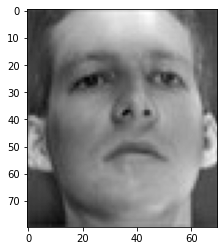

In [86]:
for i in range(len(train_set_files)):
    img = normalised_training_matrix[i].reshape(height, width)
    plt.imshow(img, cmap='gray')


In [87]:
cov_matrix = np.cov(normalised_training_matrix)
cov_matrix = np.divide(cov_matrix, 25.0)
print('Covariance Matrix Shape:', cov_matrix.shape)


Covariance Matrix Shape: (328, 328)


In [88]:
eigenvalues, eigenvectors, = np.linalg.eig(cov_matrix)
eig_pairs = [(eigenvalues[index], eigenvectors[:, index])
             for index in range(len(eigenvalues))]

# Sort the eigen pairs in descending order:
eig_pairs.sort(reverse=True)
eigvalues_sort = [eig_pairs[index][0] for index in range(len(eigenvalues))]
eigvectors_sort = [eig_pairs[index][1] for index in range(len(eigenvalues))]

sorted_ind = sorted(
    range(eigenvalues.shape[0]), key=lambda k: eigenvalues[k], reverse=True)

eigvalues_sort = eigenvalues[sorted_ind]
eigvectors_sort = eigenvectors[sorted_ind]
train_set_files_sort = np.array(train_set_files)[sorted_ind]


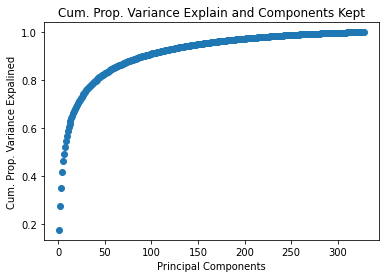

In [90]:
var_comp_sum = np.cumsum(eigvalues_sort)/sum(eigvalues_sort)

# Show cumulative proportion of varaince with respect to components
#print("Cumulative proportion of variance explained vector: \n%s" %var_comp_sum)

# x-axis for number of principal components kept
num_comp = range(1, len(eigvalues_sort)+1)
plt.title('Cum. Prop. Variance Explain and Components Kept')
plt.xlabel('Principal Components')
plt.ylabel('Cum. Prop. Variance Explained')

plt.scatter(num_comp, var_comp_sum)
plt.show()


In [91]:
reduced_data = np.array(eigvectors_sort[:125]).transpose()
reduced_data.shape


(328, 125)

In [92]:
proj_data = np.dot(training_matrix.transpose(), reduced_data)
proj_data = proj_data.transpose()
proj_data.shape


(125, 5600)

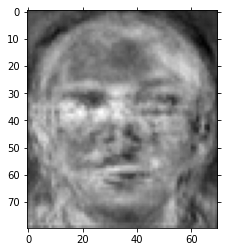

In [97]:
for i in range(proj_data.shape[0]):
    img = proj_data[i].reshape(height, width)
    plt.imshow(img, cmap='gray')
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',
                    top='off', right='off', left='off', which='both')
plt.show()


In [98]:
w = np.array([np.dot(proj_data, i) for i in normalised_training_matrix])
print(w.shape)


(328, 125)


In [107]:
#fixing this cell

def recogniser(test_image_names, train_image_names, proj_data, w, t0=2e8, prn=False):

    count = 0
    num_images = 0
    correct_pred = 0

    result = []
    wts = []

    # False match rate (FMR)
    FMR_count = 0

    # False non-match rate (FNMR)
    FNMR_count = 0

    test_image_names2 = sorted(test_image_names)


    for img in test_image_names2:

        unknown_face = io.imread("./ORL_dataset_split/test/"+img, as_gray=True)
        num_images += 1

        unknown_face_vector = np.array(unknown_face, dtype='float64').flatten()
        normalised_uface_vector = np.subtract(unknown_face_vector, mean_face)

        w_unknown = np.dot(proj_data, normalised_uface_vector)
        diff = w - w_unknown
        norms = np.linalg.norm(diff, axis=1)
        index = np.argmin(norms)

        wts.append([count, norms[index]])

        # if prn:
        #    print('Input:'+'.'.join(img.split('.')[:2]), end='\t')
        count += 1

        match = img.split('_')[0] == train_image_names[index].split('_')[0]
        if norms[index] < t0:  # It's a face
            if match:
                if prn:
                    print('Matched:' + train_image_names[index], end='\t')
                correct_pred += 1
                result.append(1)
            else:
                if prn:
                    print('F/Matched:'+train_image_names[index], end='\t')
                result.append(0)
                FMR_count += 1
        else:
            if match:
                if prn:
                    print('Unknown face!'+train_image_names[index], end='\t')
                FNMR_count += 1

            else:
                pass
                correct_pred += 1

        if prn:
            print(norms[index], end=' ')
        if prn:
            print()

    FMR = FMR_count/num_images
    FNMR = FNMR_count/num_images

    print('Correct predictions: {}/{} = {} \t\t'.format(correct_pred,
                                                        num_images, correct_pred/num_images), end=' ')
    print('FMR: {} \t'.format(FMR), end=' ')
    print('FNMR: {} \t'.format(FNMR))

    return wts, result, correct_pred, num_images, FMR, FNMR


wts, result, correct_pred, num_images, FMR, FNMR = recogniser(
    test_set_files, train_set_files, proj_data, w, t0=2e8, prn=True)


F/Matched:107_11.jpg	8308504.036111597 
F/Matched:106_11.jpg	9539778.112387365 
F/Matched:118_12.jpg	6565004.717320525 
F/Matched:113_12.jpg	5891661.8576091165 
F/Matched:13_2.jpg	4379203.057197138 
F/Matched:256_26.jpg	15493890.946454065 
F/Matched:253_26.jpg	14761155.770027379 
F/Matched:13_2.jpg	5719455.640168682 
F/Matched:134_14.jpg	3722361.07727781 
F/Matched:133_14.jpg	5924702.724141485 
F/Matched:146_15.jpg	5668279.488715473 
F/Matched:150_15.jpg	4289759.364646897 
F/Matched:235_24.jpg	20601547.742191594 
F/Matched:160_16.jpg	12675048.42719296 
F/Matched:165_17.jpg	8723603.9760994 
F/Matched:165_17.jpg	6809555.267591127 
F/Matched:179_18.jpg	5652513.573812231 
F/Matched:175_18.jpg	7433889.932665629 
F/Matched:265_27.jpg	9014925.04936129 
F/Matched:187_19.jpg	8759694.958609348 
F/Matched:193_20.jpg	8409672.863918586 
F/Matched:193_20.jpg	6773416.890479387 
F/Matched:75_8.jpg	17591019.20765006 
F/Matched:288_29.jpg	11331539.243558843 
F/Matched:294_30.jpg	13865966.087407226 
F/Ma